In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
#text to numeric
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings('ignore')

#Load Dataset

In [170]:
train_df=pd.read_csv('/content/train.txt',sep=';',header=None,names=['Text', 'Emotion'])
test_df=pd.read_csv('/content/test.txt',sep=';',header=None,names=['Text', 'Emotion'])
val_df=pd.read_csv('/content/val.txt',sep=';',header=None,names=['Text', 'Emotion'])

In [171]:
train_df.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [172]:
#shape of all dataset
print("train_df shape:-",train_df.shape)
print("test_df shape:-",test_df.shape)
print("val_df shape:-",val_df.shape)

train_df shape:- (16000, 2)
test_df shape:- (2000, 2)
val_df shape:- (2000, 2)


#concat the train and test for more data need for training for betterment of model

In [173]:
#concate the train and test dataset as to make size of training data increase
train_df=pd.concat([train_df,test_df]).reset_index(drop=True)

In [174]:
#shape of train_df
train_df.shape

(18000, 2)

In [175]:
#count the unique count in the emotion
train_df['Emotion'].value_counts()

,count
Emotion,
joy,6057
sadness,5247
anger,2434
fear,2161
love,1463
surprise,638


In [176]:
#save train_df in csv file
train_df.to_csv('train+test_df.csv',index=False)

#check the distribution of classes in all three dataset

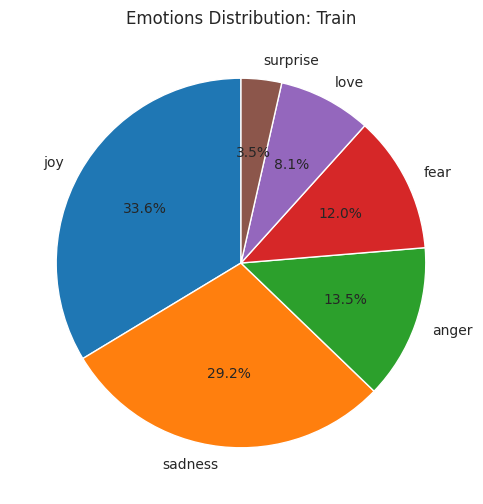

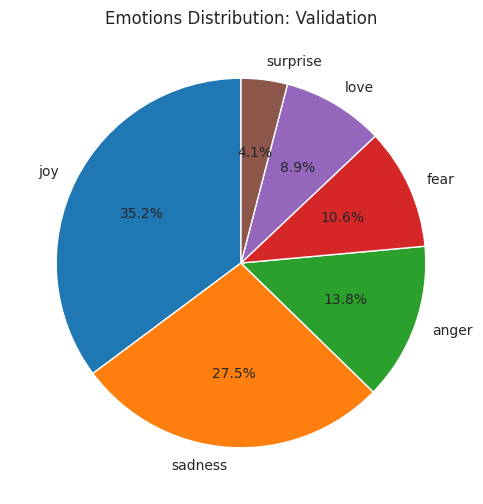

In [177]:
# Assuming train_df and val_df are defined
data = {'Train': train_df,'Validation': val_df}
# Set style outside the loop
sns.set_style("whitegrid")

for name, d in data.items():
    plt.figure(figsize=(6, 6))
    plt.pie(
        d['Emotion'].value_counts(),
        labels=d['Emotion'].value_counts().index,
        autopct='%1.1f%%',
        startangle=90
    )
    plt.title(f'Emotions Distribution: {name}')
    plt.show()

#Convert the Categorical data to Numerical

In [178]:
emotion_mapping = {
    'joy': 0,
    'sadness': 1,
    'anger': 2,
    'fear': 3,
    'love': 4,
    'surprise': 5
}

train_df['Emotion'] = train_df['Emotion'].map(emotion_mapping)
val_df['Emotion'] = val_df['Emotion'].map(emotion_mapping)

In [179]:
train_df.head()

,Text,Emotion
0,i didnt feel humiliated,1
1,i can go from feeling so hopeless to so damned...,1
2,im grabbing a minute to post i feel greedy wrong,2
3,i am ever feeling nostalgic about the fireplac...,4
4,i am feeling grouchy,2


In [180]:
#check the changes in emotion column
train_df['Emotion'].value_counts()

,count
Emotion,
0,6057
1,5247
2,2434
3,2161
4,1463
5,638


In [181]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [182]:
#print the stopword in english
print('stopwords:',stopwords.words('english'))

stopwords: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so'

#check the null values ,Duplicated values and drop it

In [183]:
#check the null values in dataset
train_df.isnull().sum().any()

False

In [184]:
val_df.isnull().sum().any()

False

In [185]:
#check the duplicates
train_df.duplicated().sum()

1

In [186]:
#drop the duplicated values
train_df.drop_duplicates(inplace=True)
val_df.drop_duplicates(inplace=True)

#Stemming the sentence

In [187]:
port_stem=PorterStemmer()

In [188]:
# Function to preprocess text
def stemming(text):
    text = re.sub('[^a-zA-Z]', ' ', text) # Remove non-alphabet characters
    text = text.lower() # Convert to lowercase
    text = text.split() # Split into words
    text = [port_stem.stem(word) for word in text if not word in stopwords.words('english')] # Remove stopwords
    text=' '.join(text)
    return text

In [189]:
#create column steammed content
train_df['stemmed_content']=train_df['Text'].apply(stemming)

In [190]:
train_df.head()

,Text,Emotion,stemmed_content
0,i didnt feel humiliated,1,didnt feel humili
1,i can go from feeling so hopeless to so damned...,1,go feel hopeless damn hope around someon care ...
2,im grabbing a minute to post i feel greedy wrong,2,im grab minut post feel greedi wrong
3,i am ever feeling nostalgic about the fireplac...,4,ever feel nostalg fireplac know still properti
4,i am feeling grouchy,2,feel grouchi


#Transform the text into Numeric for model

In [191]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, preprocessing_func):
        self.preprocessing_func = preprocessing_func

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Check if input is a pandas Series or a list
        if isinstance(X, list):
            return [self.preprocessing_func(text) for text in X]
        return X.apply(self.preprocessing_func)


#Build the model

In [192]:
# Define the pipeline
pipeline = Pipeline([
    ('text_preprocessor', TextPreprocessor(preprocessing_func=stemming)),  # Preprocess text
    ('vectorizer', TfidfVectorizer(max_features=5000)),  # Convert text to numerical features
    ('classifier', LogisticRegression(multi_class='multinomial', max_iter=200))  # Train model
])

In [193]:
# Train the pipeline
pipeline.fit(train_df['Text'], train_df['Emotion'])

Pipeline(steps=[('text_preprocessor',
                 TextPreprocessor(preprocessing_func=<function stemming at 0x7aef6e061d80>)),
                ('vectorizer', TfidfVectorizer(max_features=5000)),
                ('classifier',
                 LogisticRegression(max_iter=200, multi_class='multinomial'))])

In [194]:
# Evaluate the pipeline on validation data
y_pred_val = pipeline.predict(val_df['Text'])
print("Validation Performance:")
print(classification_report(val_df['Emotion'], y_pred_val))

Validation Performance:
              precision    recall  f1-score   support

           0       0.84      0.91      0.88       704
           1       0.85      0.91      0.88       550
           2       0.86      0.80      0.83       275
           3       0.81      0.77      0.79       212
           4       0.81      0.62      0.70       178
           5       0.83      0.62      0.71        81

    accuracy                           0.84      2000
   macro avg       0.84      0.77      0.80      2000
weighted avg       0.84      0.84      0.84      2000



#save the model

In [195]:
import joblib
joblib.dump(pipeline, 'emotion_classification_model.pkl')

['emotion_classification_model.pkl']

#load the model

In [196]:
load_pipeline=joblib.load('emotion_classification_model.pkl')

In [197]:
senetence="I feel so frustrated today!"

In [198]:
predict_emotion=load_pipeline.predict([senetence])[0]

In [199]:
emotion_maps = {
    0: 'joy',
    1: 'sadness',
    2: 'anger',
    3: 'fear',
    4: 'love',
    5: 'surprise'
}

# Map numeric prediction to emotion label
predicted_emotion_label = emotion_maps[predict_emotion]
print(f"Predicted Emotion: {predicted_emotion_label}")

Predicted Emotion: anger


#conclusion
model is working properly now we need to api to connect any application or website with this model to work on as ai model to predict from text .